### Temat 1. Własna sieć neuronowa
Przykładowe zadanie: klasyfikacja kwiatów irysa (Fisher's iris dataset)

In [3]:
using Pkg
Pkg.activate("./project")
Pkg.add("MLDatasets")
Pkg.add("IJulia")
Pkg.add("StableRNGs")
Pkg.add("DataFrames")
Pkg.add("PyPlot")
Pkg.add("MLDataUtils")

  Activating project at `e:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project`
   Resolving package versions...
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Project.toml`
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Manifest.toml`
   Resolving package versions...
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Project.toml`
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Manifest.toml`
   Resolving package versions...
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Project.toml`
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Manifest.toml`
   Resolving package versions...
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż dan

In [45]:
using RDatasets
using Random
using Plots
using DataFrames
using MLDataUtils
using Random
using Statistics

Wczytanie danych

In [5]:
iris = Matrix(dataset("datasets", "iris"))

150×5 Matrix{Any}:
 5.1  3.5  1.4  0.2  "setosa"
 4.9  3.0  1.4  0.2  "setosa"
 4.7  3.2  1.3  0.2  "setosa"
 4.6  3.1  1.5  0.2  "setosa"
 5.0  3.6  1.4  0.2  "setosa"
 5.4  3.9  1.7  0.4  "setosa"
 4.6  3.4  1.4  0.3  "setosa"
 5.0  3.4  1.5  0.2  "setosa"
 4.4  2.9  1.4  0.2  "setosa"
 4.9  3.1  1.5  0.1  "setosa"
 5.4  3.7  1.5  0.2  "setosa"
 4.8  3.4  1.6  0.2  "setosa"
 4.8  3.0  1.4  0.1  "setosa"
 ⋮                   
 6.0  3.0  4.8  1.8  "virginica"
 6.9  3.1  5.4  2.1  "virginica"
 6.7  3.1  5.6  2.4  "virginica"
 6.9  3.1  5.1  2.3  "virginica"
 5.8  2.7  5.1  1.9  "virginica"
 6.8  3.2  5.9  2.3  "virginica"
 6.7  3.3  5.7  2.5  "virginica"
 6.7  3.0  5.2  2.3  "virginica"
 6.3  2.5  5.0  1.9  "virginica"
 6.5  3.0  5.2  2.0  "virginica"
 6.2  3.4  5.4  2.3  "virginica"
 5.9  3.0  5.1  1.8  "virginica"

In [6]:
X = iris[:,1:4]
y = iris[:,5]
println("X data shape: ", size(X))
println("Y data shape: ", size(y))

X data shape: (150, 4)
Y data shape: (150,)


In [7]:
species = ["setosa", "virginica", "versicolor"]

3-element Vector{String}:
 "setosa"
 "virginica"
 "versicolor"

In [8]:
function reshape_data(data_x, data_y,species_vec)
    x_reshaped = []
    y_reshaped = []
    
    for i = 1:size(data_x)[1]
        push!(x_reshaped, data_x[i,:])
        y = zeros(3)
        if data_y[i] == species_vec[1]
            y[1] = 1.0
        elseif data_y[i] == species_vec[2]
            y[2] = 1.0
        elseif data_y[i] == species_vec[3]
            y[3] = 1.0
        end
        push!(y_reshaped,y)
    end
    
    d = [data for data in zip(x_reshaped, y_reshaped)]
    
    return d
end

data = reshape_data(X, y,species)

150-element Vector{Tuple{Vector{Any}, Vector{Float64}}}:
 ([5.1, 3.5, 1.4, 0.2], [1.0, 0.0, 0.0])
 ([4.9, 3.0, 1.4, 0.2], [1.0, 0.0, 0.0])
 ([4.7, 3.2, 1.3, 0.2], [1.0, 0.0, 0.0])
 ([4.6, 3.1, 1.5, 0.2], [1.0, 0.0, 0.0])
 ([5.0, 3.6, 1.4, 0.2], [1.0, 0.0, 0.0])
 ([5.4, 3.9, 1.7, 0.4], [1.0, 0.0, 0.0])
 ([4.6, 3.4, 1.4, 0.3], [1.0, 0.0, 0.0])
 ([5.0, 3.4, 1.5, 0.2], [1.0, 0.0, 0.0])
 ([4.4, 2.9, 1.4, 0.2], [1.0, 0.0, 0.0])
 ([4.9, 3.1, 1.5, 0.1], [1.0, 0.0, 0.0])
 ([5.4, 3.7, 1.5, 0.2], [1.0, 0.0, 0.0])
 ([4.8, 3.4, 1.6, 0.2], [1.0, 0.0, 0.0])
 ([4.8, 3.0, 1.4, 0.1], [1.0, 0.0, 0.0])
 ⋮
 ([6.0, 3.0, 4.8, 1.8], [0.0, 1.0, 0.0])
 ([6.9, 3.1, 5.4, 2.1], [0.0, 1.0, 0.0])
 ([6.7, 3.1, 5.6, 2.4], [0.0, 1.0, 0.0])
 ([6.9, 3.1, 5.1, 2.3], [0.0, 1.0, 0.0])
 ([5.8, 2.7, 5.1, 1.9], [0.0, 1.0, 0.0])
 ([6.8, 3.2, 5.9, 2.3], [0.0, 1.0, 0.0])
 ([6.7, 3.3, 5.7, 2.5], [0.0, 1.0, 0.0])
 ([6.7, 3.0, 5.2, 2.3], [0.0, 1.0, 0.0])
 ([6.3, 2.5, 5.0, 1.9], [0.0, 1.0, 0.0])
 ([6.5, 3.0, 5.2, 2.0], [0.0, 1.0, 0.0

Podział na dane treningowe i testowe

In [10]:
train, test = splitobs(shuffleobs(data), at = 0.8)

(Tuple{Vector{Any}, Vector{Float64}}[([4.8, 3.0, 1.4, 0.1], [1.0, 0.0, 0.0]), ([7.2, 3.2, 6.0, 1.8], [0.0, 1.0, 0.0]), ([6.3, 2.8, 5.1, 1.5], [0.0, 1.0, 0.0]), ([4.3, 3.0, 1.1, 0.1], [1.0, 0.0, 0.0]), ([5.8, 2.7, 5.1, 1.9], [0.0, 1.0, 0.0]), ([5.0, 3.2, 1.2, 0.2], [1.0, 0.0, 0.0]), ([6.9, 3.1, 5.1, 2.3], [0.0, 1.0, 0.0]), ([4.6, 3.4, 1.4, 0.3], [1.0, 0.0, 0.0]), ([6.9, 3.1, 4.9, 1.5], [0.0, 0.0, 1.0]), ([6.4, 3.2, 4.5, 1.5], [0.0, 0.0, 1.0])  …  ([6.7, 3.1, 5.6, 2.4], [0.0, 1.0, 0.0]), ([6.1, 2.6, 5.6, 1.4], [0.0, 1.0, 0.0]), ([4.7, 3.2, 1.3, 0.2], [1.0, 0.0, 0.0]), ([6.5, 3.0, 5.2, 2.0], [0.0, 1.0, 0.0]), ([5.5, 2.5, 4.0, 1.3], [0.0, 0.0, 1.0]), ([6.5, 3.0, 5.8, 2.2], [0.0, 1.0, 0.0]), ([5.4, 3.0, 4.5, 1.5], [0.0, 0.0, 1.0]), ([4.7, 3.2, 1.6, 0.2], [1.0, 0.0, 0.0]), ([5.7, 4.4, 1.5, 0.4], [1.0, 0.0, 0.0]), ([4.9, 3.1, 1.5, 0.2], [1.0, 0.0, 0.0])], Tuple{Vector{Any}, Vector{Float64}}[([6.9, 3.2, 5.7, 2.3], [0.0, 1.0, 0.0]), ([5.8, 4.0, 1.2, 0.2], [1.0, 0.0, 0.0]), ([5.7, 2.6, 3.5, 1.0]

Różniczkowanie w przód

In [11]:
# Zdefiniowanie struktury
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

In [12]:
# Przeciążenie podstawowych operatorów
import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
# Przeciążenie podstawowych funkcji
import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

In [13]:
# Promocja typów i konwersja
import Base: convert, promote_rule

In [14]:
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
@show Dual{Float64}[Dual(1,2), Dual(3,0)];

Dual{Float64}[Dual(1, 2), Dual(3, 0)] = Dual{Float64}[Dual{Float64}(1.0, 2.0), Dual{Float64}(3.0, 0.0)]


In [15]:
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
@show Dual{Float64}[1, 2, 3];

Dual{Float64}[1, 2, 3] = Dual{Float64}[Dual{Float64}(1.0, 0.0), Dual{Float64}(2.0, 0.0), Dual{Float64}(3.0, 0.0)]


In [16]:
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}
@show Dual(1,2) * 3;

Dual(1, 2) * 3 = Dual{Int64}(3, 6)


In [17]:
import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

In [18]:
D = derivative(f, x) = partials(f(Dual(x, one(x))))

derivative (generic function with 1 method)

In [19]:
J = function jacobian(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    
    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (i == j)
            push!(x, seed ?
                Dual(args[j], one(args[j])) :
                Dual(args[j],zero(args[j])) )
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

jacobian (generic function with 1 method)

In [21]:
H = function hessian(f, args::Vector)
    ∇f(x::Vector) = J(f, x)
    J(∇f, args)
end

hessian (generic function with 1 method)

In [22]:
import LinearAlgebra: diagm
diagonal(m) = diagm(0 => vec(m))

diagonal (generic function with 1 method)

Funkcje aktywacji

In [23]:
ReLU(x) = max(zero(x), x)
σ(x) = one(x) / (one(x) + exp(-x))
tanh(x) = 2.0 / (one(x) + exp(-2.0x)) - one(x)
softmax(x)  =  exp.(x) ./ sum(exp.(x));


Funcja kosztu

In [24]:
mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ).^2)

mean_squared_loss (generic function with 1 method)

Sieć

In [25]:
mutable struct Layer
    m::Int
    n::Int
    activation::Function
    W::Matrix
    dW::Matrix
    b::Vector
    db::Vector
end


In [26]:
function NeuralNetwork()
    layer = []
    function AddLayer(m,n,activation) layer_::Layer = Layer(m,n,activation,randn(n,m),randn(n,m),randn(n),randn(n)); push!(layer, layer_);end
    () -> (AddLayer,layer)
end

NeuralNetwork (generic function with 1 method)

In [27]:
forward(net, x, y) =
    let
        for i=1:(size(net.layer)[1])
            x = net.layer[i].activation.(reshape(net.layer[i].W, net.layer[i].n, net.layer[i].m) * x .+ net.layer[i].b)
        end 
        E = mean_squared_loss(y, x)
        return E
    end

forward (generic function with 1 method)

In [28]:
forward_w(net, x, y, w, j) =
    let 
        tmp = randn(net.layer[j].n, net.layer[j].m)
        tmp[:,:] = net.layer[j].W
        net.layer[j].W = w[:, :]
    
        for i=1:(size(net.layer)[1])
            x = net.layer[i].activation.(reshape(net.layer[i].W, net.layer[i].n, net.layer[i].m) * x .+ net.layer[i].b)
        end
         
        net.layer[j].W = tmp[:,:]
        E = mean_squared_loss(y, x)
        return E
    end

forward_w (generic function with 1 method)

In [29]:
forward_b(net, x, y, b, j) =
    let 
        tmp = randn(net.layer[j].n)
        tmp[:] = net.layer[j].b
        net.layer[j].b = b[:]
    
        for i=1:(size(net.layer)[1])
            x = net.layer[i].activation.(reshape(net.layer[i].W, net.layer[i].n, net.layer[i].m) * x .+ net.layer[i].b)
        end
         
        net.layer[j].b = tmp[:]
        E = mean_squared_loss(y, x)
        return E
    end

forward_b (generic function with 1 method)

In [30]:
backpropagation(net, x, y) =
    let
        for i=1:(size(net.layer)[1])
            net.layer[i].dW[:] = J(w-> forward_w(net,x, y, w, i), net.layer[i].dW[:])
            net.layer[i].db[:] = J(b-> forward_b(net,x, y, b, i), net.layer[i].db[:])
        end
    end


backpropagation (generic function with 1 method)

In [31]:
update(net, x, y, α::Float64) =
    let
        for i=1:(size(net.layer)[1])
            net.layer[i].W -= α * net.layer[i].dW;
            net.layer[i].b -= α * net.layer[i].db;
        end
    end


update (generic function with 1 method)

In [48]:
training(net, data_set, α::Float64) =
    let
        Loss_history = Float64[]
        for j = 1:10
            epoch_L = []
            for i = 1:(length(data_set))
                x = data_set[i][1]
                y = data_set[i][2]
                Ei = forward(net, x, y)
                push!(epoch_L, Ei)
                backpropagation(net, x, y)
                update(net, x, y, α)
            end
            push!(Loss_history, std(epoch_L))
        end

        return Loss_history
    end

training (generic function with 1 method)

In [33]:
predict(net,x) = 
    let   
        for i=1:(size(net.layer)[1])
            x = net.layer[i].activation.(reshape(net.layer[i].W, net.layer[i].n, net.layer[i].m) * x .+ net.layer[i].b)
        end

        return argmax(x)
    end

predict (generic function with 1 method)

In [34]:
accuracy(network, data_set) =
    let
        return string("Accuracy: ", sum([predict(network,x[1]) == argmax(x[2]) ? 1 : 0 for x in data_set])/length(data_set)*100, "%")
    end

accuracy (generic function with 1 method)

Utworzenie sieci

In [59]:
net = NeuralNetwork()

net.AddLayer(4, 4, tanh)
net.AddLayer(4, 3, tanh)
net.AddLayer(3, 3, tanh)

3-element Vector{Any}:
 Layer(4, 4, tanh, [-0.5936811989170308 -1.5577999726873633 -0.6161234406767674 0.4336196272869819; 0.9254145726612771 0.7798035177609629 -0.22157896951485945 -0.029190411330964932; -1.4414603738644214 -0.8931093598725464 0.06421188590067144 -0.6467752774468928; 0.1307024659005334 -0.9023527610206232 0.27393422060472855 1.2985296540185314], [-0.40554975532138426 1.2438411841768113 -0.03661066472445111 0.07169832610972623; -1.427682411740331 -1.2812530429090068 2.7669331215703035 -1.3139605495659208; 0.5896942766290914 -0.1391952993043809 0.4039410635983073 -0.7795902115109128; 0.9974475619051505 1.179597809524308 -1.7353425120414772 -1.2454111587223655], [1.1586280606506525, -0.48704220269661685, -0.31118900100972485, -0.7145607591125549], [-0.655348021334572, 0.971320854284574, -0.7243220928234003, 1.0085264959223117])
 Layer(4, 3, tanh, [-0.6966513207465287 1.238666736635454 1.0154063463720564 -1.26843246798782; 0.9614353363588359 -0.7718607815952832 -0.8018717

In [60]:
history = training(net,train,0.01)

10-element Vector{Float64}:
   0.2801351392270275
   0.08760145368988859
   0.019674973815794257
   0.0031232571198523723
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

Plots.plot(history) = Plot{Plots.GRBackend() n=1}


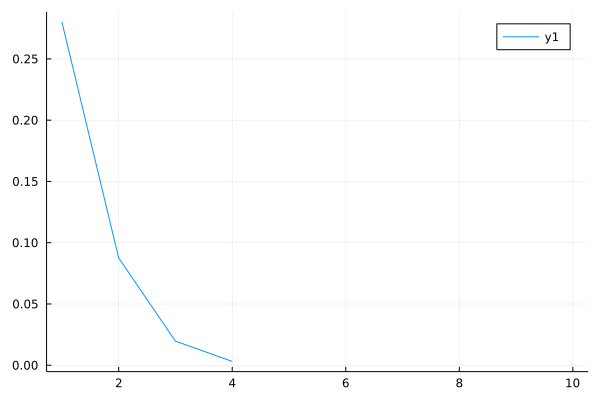

In [61]:
@show Plots.plot(history)

In [38]:
predict(net,test[2][1])

1

In [39]:
accuracy(net,test)

"Accuracy: 23.333333333333332%"